<a href="https://colab.research.google.com/github/Tikquuss/GflowNets_Tutorial/blob/main/2_Hypergrid_env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@Author TODO


In the  hyper-grid domain, the states are the cells of a n-dimensional hypercubic grid of side length $H$. The agent starts at coordinate $s = (0, 0, ..., 0)$ and is only allowed to increase one coordinate (up to H, upon which the episode terminates). A stop action indicates to terminate the trajectory. There are many action sequences that lead to the same coordinate, making this Markov Decision Process a Directed Acyclic Graph. The reward for ending the trajectory in $x$ is some $R(x) \ge 0$ (see below for examples of reward functions).

In short, the non-terminal states form a n-dimensional hypergrid with side length $H$ : $\{ (s_0, ..., s_{n-1}) \ | \ s_i \in \{0, ..., H\}, 0 \leq i \leq n-1 \}$.



In each state $s = (s_0, ..., s_{n-1})$, we have $n+1$ possible actions:
- either choose a stop action and return the state as terminal $x = T(s, stop\_action) = s$, and then compute $R(x)$ 
- or we choose one of its $n$ coordinates $i$, and increment it : $s' = T(s, i) = (s_0, ..., s_i + 1, ..., s_{n-1})$


> Example : ndim=2 (H=2, ...)
```
|  ...   |   ...  | ...    | ...
................................
| (0, 2) | (1, 2) | (2, 2) | ...
................................
| (0, 1) | (1, 1) | (2, 1) | ...
................................
| (0, 0) | (1, 0) | (2, 0) | ...
................................
```

$$R(x) = R_0 + R_1 \prod_{i=1}^{n} \mathbb{I} (0.25 < |x_i/H - 0.5|) + R_2 \prod_{i=1}^{n} \mathbb{I} (0.3 < |x_i/H - 0.5| < 0.4), \ R_0 <<< R_1 < R_2$$

$$R_{cos}(x) = R_0 + R_1 \prod_{i=1}^{n} \big(cos(50\times|x_i/H - 0.5|)+1 \big) \times f_{\mathcal{N}} \big(5\times|x_i/H - 0.5|\big) \text{, } R_0 << R_1  \text{ and } f_{\mathcal{N}} \text{ the standard normal p.d.f}$$

$$\dots$$

$$\text{Any reward function with full support or with large enough support on the grid domain.}$$

We pave the hypercube and choose the reward values to give to each pavement. The mathematical trick is the following: 
* scale each point using the application from $[0, H]$ to $[0, 1]$ : $x \mapsto \frac{x}{H}$
- calculate the distance of each point (coordinates) from the center of the hypercube: $|\frac{x}{H}-0.5|$
- and use this distance to create the paving and assign different reward values to the paving stones. 

In the first function above, the paving is at three levels : in $]0.3, 0.4[^n$ (not in terms of coordinates, but in terms of absolute distance from the center $(1/2, ..., 1/2)$ of the hypercube) the reward is equal to $R_0+R_1+R_2$ (higher mode), between $(]0.25, 0.3[ \ U \ ]0.4, 1[)^n$ the reward is equal to $R_0+R_1$, between  $[0, 0.25]^n$ the reward is equal to $R_0 <<< R_1 < R_2$ (the desert of probability).

For the function with cosine, the paving is not strict, but smooth. 
* For the term with cosine, noted that $0 \le 50 \times |\frac{x}{H}-0.5| \le 25 ∼ 8\pi$, and that the function $x \mapsto cos(x) + 1$ varies from $2$ to $0$ between $[2k\pi, (2k+1)\pi]$ and from $0$ to $2$ between $[(2k+1)\pi, 2(k+1)\pi]$ for all $k \in \mathbb{N}$. So for this term the deserts of reward are $(2k+1)\pi $ and the high modes are $2k\pi$ ($k \le 4$), from the deserts to the high modes the reward function in $cos$ is continuously increasing
* For the term with $f_{\mathcal{N}}$, noted that $0 \le 5 \times |x/H-0.5| \le 2.5$, and that $f_{\mathcal{N}(0, 1)}$ grows from $0.5$ to $0.99$ on this interval. Its high mode is therefore $0$, and the further away from $0$ (and thus from the center of the hypercube), the more it decreases.

By multiplying these two terms, instead of having peaks at regular intervals as with the $cos$ term, we have lower and lower peaks when we move away from the center of the hypercube. 

I did a plot for $n=2$ below.

# Env

## Grid domain

In [ ]:
import torch

def build_grid(ndim, H):
    """
    > Example : ndim=2 (H=2, ...)
    ```
    |  ...   |   ...  | ...    | ...
    ---------------------------------
    | (0, 2) | (1, 2) | (2, 2) | ...
    ---------------------------------
    | (0, 1) | (1, 1) | (2, 1) | ...
    ---------------------------------
    | (0, 0) | (1, 0) | (2, 0) | ...
    ---------------------------------
    ```
    """
    # We have (H+1)^ndim points, each point being of dimension ndim.
    grid_shape = (H+1,)*ndim+(ndim,) # (H+1, ..., H+1, ndim)
    grid = torch.zeros(grid_shape)
    for i in range(ndim):
        grid_i = torch.linspace(start=0, end=H, steps=H+1)
        for _ in range(i): grid_i = grid_i.unsqueeze(1)
        grid[...,i] = grid_i
    #return grid.view((H+1)**ndim,-1) # ((H+1)*ndim, ndim)
    return grid

## Reward function

In [ ]:
import numpy as np
from scipy.stats import norm

def get_reward_function(H, R0, r_cos = False, R1 = 0.5, R2 = 2):
    """ 
    x ~ (bs, n), 0 < r0 << r1 < r2
    R1 : 1e-1, 1e-2, 1e-3 ...
    """
    def R(x) :
        ax = abs(x/H - 0.5)
        return R0 + (0.25 < ax).prod(-1) * R1  + ((0.3 < ax) * (ax < 0.4)).prod(-1) * R2
        #ax = abs(x/H*2 - 1)
        #return R0 + (0.5 < ax).prod(-1) * R1  + ((0.6 < ax) * (ax < 0.8)).prod(-1) * R2

    def R_cos(x) :
        ax = abs(x/H - 0.5)
        return R0 + ((np.cos(ax * 50) + 1) * norm.pdf(ax * 5)).prod(-1) * R1

    return R if not r_cos else R_cos

##  sanity check

In [ ]:
R0, R1, R2 = 1e-2, 0.5, 2
R = get_reward_function(H=8, R0=R0, r_cos=False, R1=R1, R2=R2)
s_f = np.array([[4, 4], [0,0], [8, 8], [1,1]])
R(s_f) == np.array([R0, R0+R1, R0+R1, R0+R1+R2])

array([ True,  True,  True,  True])

In [ ]:
ndim, H = 2, 8
grid = build_grid(ndim, H)
grid, grid.shape

(tensor([[[0., 0.],
          [1., 0.],
          [2., 0.],
          [3., 0.],
          [4., 0.],
          [5., 0.],
          [6., 0.],
          [7., 0.],
          [8., 0.]],
 
         [[0., 1.],
          [1., 1.],
          [2., 1.],
          [3., 1.],
          [4., 1.],
          [5., 1.],
          [6., 1.],
          [7., 1.],
          [8., 1.]],
 
         [[0., 2.],
          [1., 2.],
          [2., 2.],
          [3., 2.],
          [4., 2.],
          [5., 2.],
          [6., 2.],
          [7., 2.],
          [8., 2.]],
 
         [[0., 3.],
          [1., 3.],
          [2., 3.],
          [3., 3.],
          [4., 3.],
          [5., 3.],
          [6., 3.],
          [7., 3.],
          [8., 3.]],
 
         [[0., 4.],
          [1., 4.],
          [2., 4.],
          [3., 4.],
          [4., 4.],
          [5., 4.],
          [6., 4.],
          [7., 4.],
          [8., 4.]],
 
         [[0., 5.],
          [1., 5.],
          [2., 5.],
          [3., 5.],
     

In [ ]:
R0, R1, R2 = 1e-2, 0.5, 2
R = get_reward_function(H=H, R0=R0, r_cos=False, R1=R1, R2=R2)
all_rewards = R(grid)
all_rewards

tensor([[0.5100, 0.5100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.5100, 0.5100],
        [0.5100, 2.5100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 2.5100, 0.5100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
        [0.5100, 2.5100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 2.5100, 0.5100],
        [0.5100, 0.5100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.5100, 0.5100]])

In [ ]:
true_dist = all_rewards.flatten().softmax(0).cpu().numpy()
true_dist

array([0.01234862, 0.01234862, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.01234862, 0.01234862, 0.01234862,
       0.09124463, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.09124463, 0.01234862, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.00748982, 0.00748982, 0.00748982, 0.01234862, 0.09124463,
       0.00748982, 0.00748982, 0.00748982, 0.00748982, 0.00748982,
       0.09124463, 0.01234862, 0.01234862, 0.01234862, 0.00748

In [ ]:
grid.view((H+1)**ndim,-1)

tensor([[0., 0.],
        [1., 0.],
        [2., 0.],
        [3., 0.],
        [4., 0.],
        [5., 0.],
        [6., 0.],
        [7., 0.],
        [8., 0.],
        [0., 1.],
        [1., 1.],
        [2., 1.],
        [3., 1.],
        [4., 1.],
        [5., 1.],
        [6., 1.],
        [7., 1.],
        [8., 1.],
        [0., 2.],
        [1., 2.],
        [2., 2.],
        [3., 2.],
        [4., 2.],
        [5., 2.],
        [6., 2.],
        [7., 2.],
        [8., 2.],
        [0., 3.],
        [1., 3.],
        [2., 3.],
        [3., 3.],
        [4., 3.],
        [5., 3.],
        [6., 3.],
        [7., 3.],
        [8., 3.],
        [0., 4.],
        [1., 4.],
        [2., 4.],
        [3., 4.],
        [4., 4.],
        [5., 4.],
        [6., 4.],
        [7., 4.],
        [8., 4.],
        [0., 5.],
        [1., 5.],
        [2., 5.],
        [3., 5.],
        [4., 5.],
        [5., 5.],
        [6., 5.],
        [7., 5.],
        [8., 5.],
        [0., 6.],
        [1

## Plots



In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker

def plot(x, y, z) :
    """https://stackoverflow.com/a/30539444/11814682"""
    xyz = {'x': x, 'y': y, 'z': z}
    # put the data into a pandas DataFrame (this is what my data looks like)
    df = pd.DataFrame(xyz, index=range(len(xyz['x']))) 

    # re-create the 2D-arrays
    x1 = np.linspace(df['x'].min(), df['x'].max(), len(df['x'].unique()))
    y1 = np.linspace(df['y'].min(), df['y'].max(), len(df['y'].unique()))
    x2, y2 = np.meshgrid(x1, y1)
    z2 = griddata((df['x'], df['y']), df['z'], (x2, y2), method='cubic')

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(x2, y2, z2, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    #surf = ax.plot_surface(x2, y2, z2 / z.sum() - 1.5, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_zlim(-1.01, 1.01)

    ax.zaxis.set_major_locator(ticker.LinearLocator(10))
    ax.zaxis.set_major_formatter(ticker.FormatStrFormatter('%.02f'))

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title('2D grid domain')

    plt.show()

In [ ]:
H = 100
N = 100
x, y = np.linspace(start = 0, stop = H, num=N), np.linspace(start = 0, stop = H, num=N)
xy = np.array(np.meshgrid(x, y)).T.reshape(-1,2) # (N*N,2)

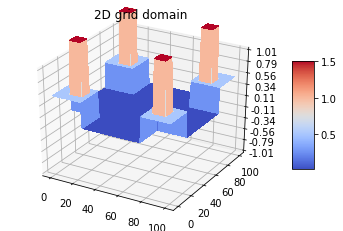

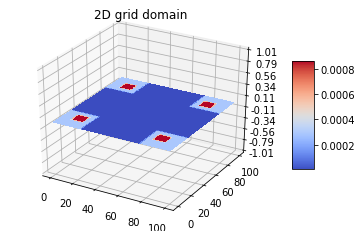

(None, None)

In [ ]:
R0, R1, R2 = 1e-2, 0.5, 1
R = get_reward_function(H=H, R0=R0, r_cos=False, R1=R1, R2=R2)
z = R(xy)
x, y = xy[:,0], xy[:,1]
plot(x, y, z), plot(x, y, z / z.sum())#, plot(x, y, z / np.log(z))

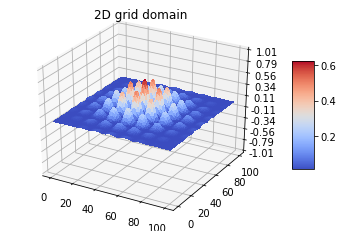

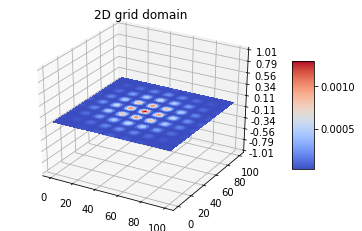

(None, None)

In [ ]:
R0, R1 = 1e-2, 1
R = get_reward_function(H=H, R0=R0, r_cos=True, R1=R1)
z = R(xy)
x, y = xy[:,0], xy[:,1]
plot(x, y, z), plot(x, y, z / z.sum())#, plot(x, y, z / np.log(z))

# Gflownet agents

In [ ]:
import torch
import numpy as np
import tqdm
import pickle

In [ ]:
#H =  4 # horizon
#H =  8 # horizon
H =  32 # horizon
#H =  100 # horizon
ndim = 2
#ndim = 4
#ndim = 6
#ndim = 8

grid = build_grid(ndim, H) # (H, ...., H, ndim)
grid = grid.view((H+1)**ndim,-1) # ((H+1)**ndim, ndim)

R0, R1, R2 = 1e-2, 0.5, 2
reward_function = get_reward_function(H=H, R0=R0, r_cos=False, R1=R1, R2=R2)
#R0, R1 = 1e-2, 1
#reward_function = get_reward_function(H, R0=R0, r_cos=True, R1=R1)

all_rewards = reward_function(grid)
#print('total reward', all_rewards.view(-1).logsumexp(0))
print('total reward', all_rewards.view(-1).sum(0))
true_dist = all_rewards.flatten().softmax(0).cpu().numpy()

total reward tensor(210.8900)




## For debugging

Once our model is trained, we will generate some terminal states, display their rewards and see if they match the figure below



In [ ]:
ar = all_rewards.reshape((H+1,)*ndim)

In [ ]:
if ndim == 2 :
  print(ar)

tensor([[0.5100, 0.5100, 0.5100,  ..., 0.5100, 0.5100, 0.5100],
        [0.5100, 0.5100, 0.5100,  ..., 0.5100, 0.5100, 0.5100],
        [0.5100, 0.5100, 0.5100,  ..., 0.5100, 0.5100, 0.5100],
        ...,
        [0.5100, 0.5100, 0.5100,  ..., 0.5100, 0.5100, 0.5100],
        [0.5100, 0.5100, 0.5100,  ..., 0.5100, 0.5100, 0.5100],
        [0.5100, 0.5100, 0.5100,  ..., 0.5100, 0.5100, 0.5100]])


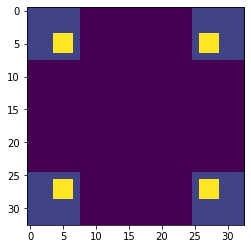

In [ ]:
if ndim == 2 :
    plt.imshow(ar)
else :
    plt.imshow(ar[0,0])

In [ ]:
if ndim == 4 :
    plt.imshow(ar.sum((0,1)),vmin=0);plt.show()

## Utils



In [ ]:
def make_mlp(l, act=torch.nn.LeakyReLU(), tail=[]):
    return torch.nn.Sequential(*(sum(
        [[torch.nn.Linear(i, o)] + ([act] if n < len(l)-2 else [])
         for n, (i, o) in enumerate(zip(l, l[1:]))], []) + tail))



---
**Re-execute the following cells each time H changes**


In [ ]:
def one_hot_embedding(states, num_classes = H+1):
    # states : (bs, ndim) -> (bs, embedding_dim), embedding_dim = num_classes x ndim
    assert num_classes >= H + 1
    return torch.nn.functional.one_hot(states, num_classes).view(states.shape[0],-1).float()

The following function allows to associate a unique index to each state of the grid environment.\
Given that a coordinate can take $H+1$ values (from $0$ to $H$), it is enough to write them in this base to ensure the uniqueness.\
$$Index \bigg(s = (s_i)_{i=0}^{ndim-1} \bigg) = \sum_{i=0}^{ndim-1} s_i (H+1)^i $$
To find a state given its index, just invoke `grid[index]`

In [ ]:
base_coordinates = (H+1)**torch.arange(ndim) # [(H+1)^0, ..., (H+1)^(ndim-1)]

In [ ]:
def get_state_index(states):
    """
    This function allows to associate a unique index to each state of the grid environment.
    To find a state given its index, just invoke grid[state_index]
    > params : 
        * states ~ Tensor(num_states, ndim), batch_size can be zero (for single state)
    """
    state_index = (states*base_coordinates).sum().item()
    return state_index # (num_states,)

def get_state(indexes) :
    """
    This function allows to find a state given its index
    > params : 
        * indexes  ~ LongTensor(num_states,) or int (for single state)
    """
    return grid[indexes] # (num_states, ndim)

sanity check

In [ ]:
for i, states in enumerate(grid) :
    assert i == get_state_index(states)



---



In [ ]:
from typing import List

def get_modes_founds_old(first_visit : List[int], threshold : float = R2, max_steps : int = None) :
    """Calculates the modes (R >= threshold) found for each episode
    """
    n = max_steps if max_steps is not None else n_train_steps
    xs = range(n)
    #modes_founds = [(reward_function(torch.stack([get_state(s) for s in list(set(np.where(first_visit == i)[0]))])) >= threshold).sum() for i in xs]
    modes_founds = [0]*n
    for i in xs :
        states_i = list(set(np.where((0 <= first_visit) & (first_visit <= i))[0]))
        states_i = get_state(torch.LongTensor(states_i))
        r = reward_function(states_i)
        modes_founds[i] = (r >= threshold).sum().item()
    
    return modes_founds, [(i+1)*batch_size for i in xs]

def get_modes_founds(first_visit : List[int], modes : List[bool], max_steps : int = None) :
    """
    Calculates the modes (R >= threshold) found for each episode.
    Make sure first_visit and all_rewards have same shape
    * ```modes = all_rewards >= threshold```
    """
    n = max_steps if max_steps is not None else n_train_steps
    ### numpy
    # #modes_founds = ((first_visit<np.arange(n_train_steps).unsqueeze(1)) - (first_visit==-1)) * batch_size
    # first_visit = first_visit[modes] # (n_modes,)
    # modes_founds = (0 <= first_visit) & (first_visit <= np.arange(n)[...,np.newaxis]) # (n, n_modes)
    # pytorch
    first_visit = torch.from_numpy(first_visit)[modes] # (n_modes,)
    modes_founds = (0 <= first_visit) & (first_visit <= torch.arange(n).unsqueeze(1)) # (n, n_modes)

    return modes_founds.sum(1), np.arange(1, n+1)*batch_size

## Paramaters



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
n_hid = 256
n_layers = 2

batch_size = 128

minus_inf = -1e8

# set PB to uniform distribution (and learn just PF) or not 
uniform_PB = False

In [ ]:
#n_train_steps = 50000
n_train_steps = 5000
#n_train_steps = 1000
#n_train_steps = 50

## Trajectory Balance objective

$$ 
\mathcal{L}_{TB} \big(\tau = (s_0, ..., s_n = x) \big) = \bigg( log \frac{Z_{\theta} \prod_{t=1}^{n} P_{F} (s_t | s_{t-1}; \theta) }{R(x) \prod_{t=1}^{n} P_{B} (s_{t-1} | s_t; \theta) } \bigg)^2
\\= \bigg[ log(Z_{\theta}) + \sum_{t=1}^{n} \bigg( - log\big( P_{B} (s_{t-1} | s_t; \theta)\big) + log\big(P_{F} (s_t | s_{t-1}; \theta)\big) \bigg) - log \big(R(x)\big) \bigg]^2
$$

In [ ]:
input_dim = ndim*(H+1) # embedding dim
output_dim = 2*ndim+1 # ndim + 1 for P_F (+1 for stop action) and ndim for P_B 
model_TB = make_mlp([input_dim] + [n_hid] * n_layers + [output_dim]).to(device)
logZ_TB = torch.zeros((1,)).to(device) # log (initial state flow), Z = 1
optimizer = torch.optim.Adam([ {'params':model_TB.parameters(), 'lr':0.001}, {'params':[logZ_TB], 'lr':0.1} ])
logZ_TB.requires_grad_()

model_TB

Sequential(
  (0): Linear(in_features=66, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=5, bias=True)
)

In [ ]:
losses_TB = []
rewards_TB = []
logZ_TB_list = []
all_visited_TB = []
first_visit_TB = -1 * np.ones_like(true_dist)
l1log_TB = []

In [ ]:
for it in tqdm.trange(n_train_steps):
    
    # TB loss for each trajectory
    loss_TB = torch.zeros((batch_size,)).to(device)
    loss_TB += logZ_TB # see the equation above
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
    # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
    actions = None # (current_batch_size,)

    while torch.any(~dones):

        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
        logits = model_TB(embed) # (current_batch_size, output_dim) 
        
        ### Backward Policy ### 
        PB_logits = logits[...,ndim+1:2*ndim+1] # (current_batch_size, ndim)
        PB_logits = PB_logits * (0 if uniform_PB else 1) # (current_batch_size, ndim)
        # Being in a edge cell -- (a zero coordinate), we can't move backward
        edge_mask = (non_terminal_states == 0).float() # (current_batch_size, ndim)
        logPB = (PB_logits + minus_inf*edge_mask).log_softmax(1) # (current_batch_size, ndim)
        # add -logPB to the loss
        if actions is not None: 
            """
            Gather along the parents' dimension (1) to select the logPB of the previously chosen actions, while avoiding the actions leading 
            to terminal states (action==ndim). The reason of using the previous chosen actions is that PB is calculated on the same trajectory as PF
            See below for the calculation of `action`. We avoid actions leading to terminal states because a terminal state can't be parent of another 
            state
            """
            loss_TB[~dones] -= logPB.gather(1, actions[actions != ndim].unsqueeze(1)).squeeze(1)

        ### Forward Policy ### 
        PF_logits = logits[...,:ndim+1] # (current_batch_size, ndim+1) 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # logPF (with mask)
        logPF = (PF_logits + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        sample_temperature = 1
        #exp_weight = 0.
        #sample_ins_probs = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
        sample_ins_probs = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        #actions = torch.distributions.categorical.Categorical(probs = sample_ins_probs).sample() # (current_batch_size,)
        #actions = torch.multinomial(probs = sample_ins_probs, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
        actions = sample_ins_probs.multinomial(1) # (current_batch_size,)
        # add logPF to the loss : gather along the children's dimension (1) to select the logPF for the chosen actions
        loss_TB[~dones] += logPF.gather(1, actions).squeeze(1)

        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)
        for state in non_terminal_states[terminates]: 
            state_index = get_state_index(state.cpu())
            if first_visit_TB[state_index]<0: first_visit_TB[state_index] = it
            all_visited_TB.append(state_index)
        
        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))
        
    R = reward_function(states.float())
    loss_TB -= R.log()
    loss = (loss_TB**2).sum()/batch_size

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_TB.append(loss.item())
    rewards_TB.append(R.mean().cpu())
    logZ_TB_list.append(logZ_TB.item())

    if it%100==0: 
        print('\nloss =', np.array(losses_TB[-100:]).mean(), 'logZ =', logZ_TB.item(), "R =", np.array(rewards_TB[-100:]).mean())
        emp_dist = np.bincount(all_visited_TB[-200000:], minlength=len(true_dist)).astype(float)
        emp_dist /= emp_dist.sum()
        l1 = np.abs(true_dist-emp_dist).mean()
        print('L1 =', l1)
        l1log_TB.append((len(all_visited_TB), l1))

  0%|          | 2/5000 [00:00<11:29,  7.25it/s]


loss = 5.628333568572998 logZ = 0.09999999403953552 R = 0.52953124
L1 = 0.001778725696686156


  2%|▏         | 102/5000 [00:17<10:21,  7.88it/s]


loss = 1.78291807025671 logZ = 4.135488986968994 R = 0.86250013
L1 = 0.0013702014601213934


  4%|▍         | 202/5000 [00:31<11:26,  6.99it/s]


loss = 0.5742632935196161 logZ = 5.280782699584961 R = 1.2209768
L1 = 0.000986035780049603


  6%|▌         | 302/5000 [00:46<12:27,  6.29it/s]


loss = 0.04529868707060814 logZ = 5.328988552093506 R = 1.3409374
L1 = 0.0008484788044541983


  8%|▊         | 402/5000 [01:01<11:56,  6.42it/s]


loss = 0.01844014646951109 logZ = 5.328639984130859 R = 1.3551171
L1 = 0.0008142327996237067


 10%|█         | 502/5000 [01:16<11:20,  6.61it/s]


loss = 0.010433530427981168 logZ = 5.33644962310791 R = 1.3458202
L1 = 0.0008219010561917563


 12%|█▏        | 602/5000 [01:31<10:56,  6.70it/s]


loss = 0.011155250065494329 logZ = 5.329713821411133 R = 1.3734764
L1 = 0.0008319790157654365


 14%|█▍        | 702/5000 [01:46<11:10,  6.41it/s]


loss = 0.008212211115751416 logZ = 5.3406596183776855 R = 1.3804686
L1 = 0.0008397900719583341


 16%|█▌        | 802/5000 [02:02<11:01,  6.34it/s]


loss = 0.012371844133595005 logZ = 5.340714454650879 R = 1.3629686
L1 = 0.0008446476940957603


 18%|█▊        | 902/5000 [02:17<10:38,  6.42it/s]


loss = 0.008148455801419914 logZ = 5.338907241821289 R = 1.3625779
L1 = 0.0008492869687980526


 20%|██        | 1002/5000 [02:32<09:47,  6.81it/s]


loss = 0.011026920803124085 logZ = 5.329413414001465 R = 1.355703
L1 = 0.0008521966287347992


 22%|██▏       | 1102/5000 [02:47<09:55,  6.55it/s]


loss = 0.016485069857444613 logZ = 5.3343424797058105 R = 1.3725389
L1 = 0.0008548253445309211


 24%|██▍       | 1202/5000 [03:02<09:24,  6.72it/s]


loss = 0.01704291391884908 logZ = 5.347470760345459 R = 1.3616796
L1 = 0.0008563711822690463


 26%|██▌       | 1302/5000 [03:17<10:09,  6.06it/s]


loss = 0.016078759199008346 logZ = 5.330785751342773 R = 1.3592967
L1 = 0.0008578448085068254


 28%|██▊       | 1402/5000 [03:32<08:55,  6.72it/s]


loss = 0.01280792518693488 logZ = 5.34039306640625 R = 1.3674998
L1 = 0.0008593743401128751


 30%|███       | 1502/5000 [03:48<09:31,  6.13it/s]


loss = 0.019414019254036248 logZ = 5.346449851989746 R = 1.3490623
L1 = 0.0008601265313698846


 32%|███▏      | 1602/5000 [04:03<08:45,  6.47it/s]


loss = 0.014356851861812174 logZ = 5.348987579345703 R = 1.3586327
L1 = 0.0008653938401551512


 34%|███▍      | 1702/5000 [04:19<08:21,  6.58it/s]


loss = 0.01011250057257712 logZ = 5.359898567199707 R = 1.351992
L1 = 0.0008779099099439482


 36%|███▌      | 1802/5000 [04:34<08:25,  6.32it/s]


loss = 0.008463301360607148 logZ = 5.346924304962158 R = 1.3449998
L1 = 0.0008784057777125432


 38%|███▊      | 1902/5000 [04:49<08:15,  6.25it/s]


loss = 0.005478061276953668 logZ = 5.343153476715088 R = 1.3550389
L1 = 0.0008769089916703025


 40%|████      | 2002/5000 [05:05<08:02,  6.21it/s]


loss = 0.0031735188351012765 logZ = 5.354211807250977 R = 1.3458202
L1 = 0.0008760458144434891


 42%|████▏     | 2102/5000 [05:20<07:27,  6.48it/s]


loss = 0.002414415905368514 logZ = 5.359030723571777 R = 1.345078
L1 = 0.0008743102772534064


 44%|████▍     | 2202/5000 [05:35<07:20,  6.35it/s]


loss = 0.0014351527384133078 logZ = 5.353431701660156 R = 1.3358202
L1 = 0.0008729512322579978


 46%|████▌     | 2302/5000 [05:51<07:07,  6.30it/s]


loss = 0.0012332153940224088 logZ = 5.352160453796387 R = 1.3472655
L1 = 0.0008720329586124514


 48%|████▊     | 2402/5000 [06:06<06:57,  6.23it/s]


loss = 0.00131919666135218 logZ = 5.355493545532227 R = 1.3470702
L1 = 0.0008706279999347654


 50%|█████     | 2502/5000 [06:22<06:31,  6.38it/s]


loss = 0.0013849276874680072 logZ = 5.349582195281982 R = 1.3568358
L1 = 0.0008697097262892192


 52%|█████▏    | 2602/5000 [06:37<06:13,  6.43it/s]


loss = 0.0011863567828550004 logZ = 5.352218151092529 R = 1.3421874
L1 = 0.0008685894324416526


 54%|█████▍    | 2702/5000 [06:52<05:41,  6.73it/s]


loss = 0.0011416754854144528 logZ = 5.34600305557251 R = 1.3425779
L1 = 0.0008670100017713128


 56%|█████▌    | 2802/5000 [07:07<05:38,  6.50it/s]


loss = 0.0019052506890147925 logZ = 5.348293304443359 R = 1.342539
L1 = 0.0008664957685298069


 58%|█████▊    | 2902/5000 [07:23<05:31,  6.33it/s]


loss = 0.0014822547981748358 logZ = 5.35621452331543 R = 1.3526951
L1 = 0.0008656325913029933


 60%|██████    | 3002/5000 [07:38<05:11,  6.42it/s]


loss = 0.0023967039538547396 logZ = 5.353648662567139 R = 1.3404295
L1 = 0.0008647326831303577


 62%|██████▏   | 3102/5000 [07:54<05:09,  6.13it/s]


loss = 0.005494735561078414 logZ = 5.348416805267334 R = 1.3426951
L1 = 0.0008640990743149307


 64%|██████▍   | 3202/5000 [08:09<04:52,  6.16it/s]


loss = 0.005218944337684661 logZ = 5.349833011627197 R = 1.3469529
L1 = 0.0008638695059035443


 66%|██████▌   | 3302/5000 [08:25<04:28,  6.33it/s]


loss = 0.0058119719568639995 logZ = 5.346216678619385 R = 1.3516796
L1 = 0.0008636583029650685


 68%|██████▊   | 3402/5000 [08:40<04:17,  6.22it/s]


loss = 0.0025849097920581697 logZ = 5.35282039642334 R = 1.3396873
L1 = 0.0008632634452974836


 70%|███████   | 3502/5000 [08:55<03:44,  6.67it/s]


loss = 0.0024502310279058293 logZ = 5.351184844970703 R = 1.3424608
L1 = 0.0008632634452974836


 72%|███████▏  | 3602/5000 [09:10<03:31,  6.62it/s]


loss = 0.0015901357040274888 logZ = 5.348814964294434 R = 1.3441795
L1 = 0.0008634654654995037


 74%|███████▍  | 3702/5000 [09:26<03:18,  6.53it/s]


loss = 0.0011742146176402456 logZ = 5.355237007141113 R = 1.3625389
L1 = 0.000863667485701524


 76%|███████▌  | 3802/5000 [09:41<03:03,  6.52it/s]


loss = 0.0021212736348388715 logZ = 5.349887371063232 R = 1.3365624
L1 = 0.0008634195518172265


 78%|███████▊  | 3902/5000 [09:55<02:49,  6.49it/s]


loss = 0.003614989003399387 logZ = 5.356720447540283 R = 1.3418748
L1 = 0.0008635389273911474


 80%|████████  | 4002/5000 [10:10<02:28,  6.71it/s]


loss = 0.002977787685813382 logZ = 5.347593307495117 R = 1.3455858
L1 = 0.0008633828208714046


 82%|████████▏ | 4102/5000 [10:25<02:16,  6.56it/s]


loss = 0.0042907516693230716 logZ = 5.345900535583496 R = 1.358164
L1 = 0.0008638603231670887


 84%|████████▍ | 4202/5000 [10:40<02:05,  6.36it/s]


loss = 0.002906727121444419 logZ = 5.342167377471924 R = 1.3398045
L1 = 0.0008643929218815057


 86%|████████▌ | 4302/5000 [10:56<01:46,  6.57it/s]


loss = 0.002412941889488138 logZ = 5.364588260650635 R = 1.3480858
L1 = 0.0008644112873544166


 88%|████████▊ | 4402/5000 [11:10<01:31,  6.53it/s]


loss = 0.004100368832005188 logZ = 5.349205017089844 R = 1.343203
L1 = 0.0008640164296868317


 90%|█████████ | 4502/5000 [11:25<01:16,  6.49it/s]


loss = 0.0015340748731978238 logZ = 5.342836380004883 R = 1.349453
L1 = 0.0008640898915784755


 92%|█████████▏| 4602/5000 [11:41<01:03,  6.27it/s]


loss = 0.001327568173292093 logZ = 5.354628562927246 R = 1.3407811
L1 = 0.0008639888814774652


 94%|█████████▍| 4702/5000 [11:56<00:44,  6.63it/s]


loss = 0.0017095171532128005 logZ = 5.352619171142578 R = 1.3485936
L1 = 0.0008641082570513863


 96%|█████████▌| 4802/5000 [12:11<00:31,  6.29it/s]


loss = 0.0033637633302714674 logZ = 5.3555073738098145 R = 1.3414452
L1 = 0.0008635756583369694


 98%|█████████▊| 4902/5000 [12:26<00:15,  6.33it/s]


loss = 0.0077345301583409305 logZ = 5.345482349395752 R = 1.3267968
L1 = 0.0008634379172901373


100%|██████████| 5000/5000 [12:41<00:00,  6.57it/s]


### samples

In [ ]:
#model_TB, logZ_TB, losses_TB, rewards_TB, logZ_TB_list, all_visited_TB, first_visit_TB, l1log_TB = data["TB"]

In [ ]:
samples_TB = np.zeros((H+1,)*ndim)

In [ ]:
for it in tqdm.trange(500):
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
    # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
    actions = None # (current_batch_size,)

    while torch.any(~dones):

        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
        with torch.no_grad():
            logits = model_TB(embed) # (current_batch_size, output_dim) 
        
        ### Forward Policy ### 
        PF_logits = logits[...,:ndim+1] # (current_batch_size, ndim+1) 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # logPF (with mask)
        logPF = (PF_logits + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        sample_temperature = 1
        #exp_weight = 0.
        #sample_ins_probs = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
        sample_ins_probs = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        #actions = torch.distributions.categorical.Categorical(probs = sample_ins_probs).sample() # (current_batch_size,)
        #actions = torch.multinomial(probs = sample_ins_probs, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
        actions = sample_ins_probs.multinomial(1) # (current_batch_size,)
        
        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)
        
        # Update dones
        dones[~dones] |= terminates
        
        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))
    
    if ndim == 8 :
        for a,b,c,d,e,f,g,h in states: samples_TB[a,b,c,d,e,f,g,h]+=1
    if ndim == 6 :
        for a,b,c,d,e,f in states: samples_TB[a,b,c,d,e,f]+=1
    if ndim == 4 :
        for a,b,c,d in states: samples_TB[a,b,c,d]+=1
    elif ndim == 2 :
        for a,b in states: samples_TB[a,b]+=1

100%|██████████| 500/500 [00:28<00:00, 17.58it/s]


In [ ]:
if ndim == 2 :
    print(samples_TB / samples_TB.sum())

[[0.00259375 0.00201563 0.00245313 ... 0.00254688 0.00253125 0.00196875]
 [0.00234375 0.00198438 0.00253125 ... 0.00228125 0.002375   0.00253125]
 [0.00239062 0.00242187 0.00215625 ... 0.00253125 0.00232812 0.00265625]
 ...
 [0.00276562 0.00245313 0.00214063 ... 0.00226562 0.00251563 0.00285937]
 [0.00226562 0.0023125  0.00257813 ... 0.00264063 0.002375   0.0020625 ]
 [0.00235937 0.002375   0.00245313 ... 0.00264063 0.00192187 0.00254688]]


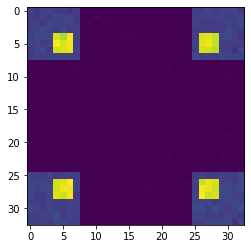

In [ ]:
if ndim == 2 :
    plt.imshow(samples_TB)
elif ndim == 4 :
    plt.imshow(samples_TB[0,0])
elif ndim == 6:  
    plt.imshow(samples_TB[0,0,0,0])
elif ndim == 8:  
    plt.imshow(samples_TB[0,0,0,0,0,0])

In [ ]:
if ndim == 4 :
    tmp = samples_TB.sum((2,3))+samples_TB.sum((0,1))+samples_TB.sum((0,2))+samples_TB.sum((1,3))+samples_TB.sum((2,3))+samples_TB.sum((0,3))
    plt.imshow(tmp,vmin=0);plt.show()
    plt.imshow(samples_TB.sum((1,3)),vmin=0);plt.show()

## Detailed balance objective

$$ 
\mathcal{L}_{DB} \big(s, s' \big) = \left\{
    \begin{array}{ll}
        \bigg( log \frac{F_{\theta}(s) P_{F} (s' | s; \theta)}{R(s') P_{B} (s | s'; \theta) } \bigg)^2 & \mbox{if } s' \mbox{ terminal} \\
        \bigg( log \frac{F_{\theta}(s) P_{F} (s' | s; \theta) }{F_{\theta}(s') P_{B} (s | s'; \theta) } \bigg)^2 & \mbox{else.}
    \end{array}
\right. 
\\= \left\{
    \begin{array}{ll}
        \bigg[ log(F_{\theta} (s)) - log\big( P_{B} (s' | s; \theta)\big) + log\big(P_{F} (s | s'; \theta)\big) - log(R(s'))  \bigg]^2 & \mbox{if } s' \mbox{ terminal} \\
        \bigg[ log(F_{\theta} (s)) - log(F_{\theta} (s')) - log\big( P_{B} (s' | s; \theta)\big) + log\big(P_{F} (s | s'; \theta)\big) \bigg]^2 & \mbox{else.}
    \end{array}
\right. 
$$

In [ ]:
input_dim = ndim*(H+1) # embedding dim
output_dim = 2*ndim+2 # ndim + 1 for P_F (+1 for stop action), ndim for P_B, and 1 for F
model_DB = make_mlp([input_dim] + [n_hid] * n_layers + [output_dim]).to(device)
logZ_DB = torch.zeros((1,)).to(device) # log (initial state flow), Z = 1
optimizer = torch.optim.Adam([{'params':model_DB.parameters(), 'lr':0.001}])

model_DB

Sequential(
  (0): Linear(in_features=66, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=6, bias=True)
)

In [ ]:
losses_DB = []
rewards_DB = []
logZ_DB_list = []
all_visited_DB = []
first_visit_DB = -1 * np.ones_like(true_dist)
l1log_DB = []

In [ ]:
for it in tqdm.trange(n_train_steps):
    
    # DB loss for each state of each trajectory : a trajectory can have a maximum length (#states) of `(H+1) + H + ... + H = (H+1) + (ndim-1)*H`
    loss_DB = torch.zeros((batch_size, H+1+(ndim-1)*H)).to(device)
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
    # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
    actions = None # (current_batch_size,)

    i = 0
    while torch.any(~dones):

        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
        logits = model_DB(embed) # (current_batch_size, output_dim) 

        ### logF ### 
        logF = logits[...,2*ndim+1] # (current_batch_size,)
        loss_DB[~dones,i] += logF # add logF(s_i) to the loss L(s_i, s_{i+1})
        if i>0: loss_DB[~dones,i-1] -= logF # add -logF(s_i) to the loss L(s_{i-1}, s_i)
        #else : logZ_DB[:] = logF.mean().item() # initial state : Z = F(s_0)
        else: logZ_DB[:] = logF[0].item() # initial state : Z = F(s_0)
        
        ### Backward Policy ### 
        PB_logits = logits[...,ndim+1:2*ndim+1] # (current_batch_size, ndim)
        PB_logits = PB_logits * (0 if uniform_PB else 1) # (current_batch_size, ndim)
        # Being in a edge cell -- (a zero coordinate), we can't move backward
        edge_mask = (non_terminal_states == 0).float() # (current_batch_size, ndim)
        logPB = (PB_logits + minus_inf*edge_mask).log_softmax(1) # (current_batch_size, ndim)
        # add -logPB(s_{i-1} | s_i) to the loss L(s_{i-1}, s_i)
        if actions is not None: 
            """
            Gather along the parents' dimension (1) to select the logPB of the previously chosen actions, while avoiding the actions leading 
            to terminal states (action==ndim). The reason of using the previous chosen actions () is that PB is calculated on the same trajectory as PF
            See below for the calculation of `action`. We avoid actions leading to terminal states because a terminal state can't be parent of another 
            state
            """
            loss_DB[~dones,i-1] -= logPB.gather(1, actions[actions!=ndim].unsqueeze(1)).squeeze(1)
    
        ### Forward Policy ### 
        PF_logits = logits[...,:ndim+1] # (current_batch_size, ndim+1) 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # logPF (with mask)
        logPF = (PF_logits + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        sample_temperature = 1
        #exp_weight= 0.
        #sample_ins_probs = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
        sample_ins_probs = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        #actions = torch.distributions.categorical.Categorical(probs = sample_ins_probs).sample() # (current_batch_size,)
        #actions = torch.multinomial(probs = sample_ins_probs, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
        actions = sample_ins_probs.multinomial(1) # (current_batch_size,)
        # add logPF(s_i | s_{i+1}) to the loss L(s_i, s_{i+1}) : gather along the children's dimension (1) to select the logPF for the chosen actions
        loss_DB[~dones,i] += logPF.gather(1, actions).squeeze(1)

        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)
        for state in non_terminal_states[terminates]: 
            state_index = get_state_index(state.cpu())
            if first_visit_DB[state_index]<0: first_visit_DB[state_index] = it
            all_visited_DB.append(state_index)

        # Add reward for terminal state
        termination_mask = ~dones
        termination_mask[~dones] &= terminates
        R_x = reward_function(non_terminal_states[terminates].float()) 
        loss_DB[termination_mask,i] -= (R_x + 1e-8).log()
        
        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))
            
        i += 1

    #lens = states.sum(1)+1 # number of actions taken for each trajectory
    #loss = (loss_DB**2).sum()/lens.sum() 
    loss = (loss_DB**2).sum(dim=1).sum()/batch_size

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_DB.append(loss.item())
    R = reward_function(states.float())
    rewards_DB.append(R.mean().cpu())
    logZ_DB_list.append(logZ_DB.item())

    if it%100==0: 
        print('\nloss =', np.array(losses_DB[-100:]).mean(), 'logZ =', logZ_DB.item(), "R =", np.array(rewards_DB[-100:]).mean())
        emp_dist = np.bincount(all_visited_DB[-200000:], minlength=len(true_dist)).astype(float)
        emp_dist /= emp_dist.sum()
        l1 = np.abs(true_dist-emp_dist).mean()
        print('L1 =', l1)
        l1log_DB.append((len(all_visited_DB), l1))

  0%|          | 6/5000 [00:00<03:24, 24.46it/s]


loss = 1.558149814605713 logZ = 0.009096775203943253 R = 0.53734374
L1 = 0.0017672830119218482


  2%|▏         | 102/5000 [00:15<15:26,  5.29it/s]


loss = 1.5978898778557777 logZ = 4.348416805267334 R = 0.673672
L1 = 0.0012334472556907936


  4%|▍         | 201/5000 [00:34<16:15,  4.92it/s]


loss = 0.18652499176561832 logZ = 4.8478617668151855 R = 1.0249221
L1 = 0.001126958386272558


  6%|▌         | 302/5000 [00:54<15:50,  4.94it/s]


loss = 0.05439641799777746 logZ = 5.2593536376953125 R = 1.2181252
L1 = 0.000991876756069694


  8%|▊         | 401/5000 [01:15<15:21,  4.99it/s]


loss = 0.01430265350267291 logZ = 5.3503031730651855 R = 1.3126172
L1 = 0.0009097025461818147


 10%|█         | 501/5000 [01:35<15:17,  4.90it/s]


loss = 0.008057421322446317 logZ = 5.354135513305664 R = 1.3220311
L1 = 0.0008761998705329709


 12%|█▏        | 601/5000 [01:55<15:20,  4.78it/s]


loss = 0.015733420285396277 logZ = 5.328025817871094 R = 1.3427342
L1 = 0.0008574659068625308


 14%|█▍        | 701/5000 [02:16<15:27,  4.63it/s]


loss = 0.011471149037824944 logZ = 5.347069263458252 R = 1.3582029
L1 = 0.000843843818232374


 16%|█▌        | 801/5000 [02:37<14:15,  4.91it/s]


loss = 0.010416160633321852 logZ = 5.344133377075195 R = 1.349453
L1 = 0.0008401615167739673


 18%|█▊        | 901/5000 [02:58<13:52,  4.93it/s]


loss = 0.009269262327579781 logZ = 5.342678070068359 R = 1.3547654
L1 = 0.000843633751120317


 20%|██        | 1001/5000 [03:18<14:04,  4.74it/s]


loss = 0.01088442777749151 logZ = 5.354400634765625 R = 1.3515624
L1 = 0.000846276813930687


 22%|██▏       | 1101/5000 [03:39<14:05,  4.61it/s]


loss = 0.007162615957204252 logZ = 5.344970703125 R = 1.3472655
L1 = 0.0008481009292110141


 24%|██▍       | 1201/5000 [03:59<12:41,  4.99it/s]


loss = 0.003673955469275825 logZ = 5.350367546081543 R = 1.3394139
L1 = 0.0008497049055437277


 26%|██▌       | 1301/5000 [04:20<12:01,  5.13it/s]


loss = 0.0018475863302592189 logZ = 5.354638576507568 R = 1.3610154
L1 = 0.0008510292205823001


 28%|██▊       | 1401/5000 [04:40<11:56,  5.02it/s]


loss = 0.001489284207636956 logZ = 5.3502044677734375 R = 1.3428905
L1 = 0.0008518367620088186


 30%|███       | 1501/5000 [05:00<12:36,  4.62it/s]


loss = 0.003605639754823642 logZ = 5.33585262298584 R = 1.3527733
L1 = 0.0008530815647146582


 32%|███▏      | 1601/5000 [05:20<11:46,  4.81it/s]


loss = 0.0018282278343394864 logZ = 5.350903511047363 R = 1.343906
L1 = 0.0008593424168310006


 34%|███▍      | 1701/5000 [05:40<10:54,  5.04it/s]


loss = 0.0002275919979729224 logZ = 5.350683212280273 R = 1.3239452
L1 = 0.0008695168888236544


 36%|███▌      | 1801/5000 [06:01<11:30,  4.63it/s]


loss = 0.00020419184511411004 logZ = 5.351454734802246 R = 1.3459374
L1 = 0.0008705269898337554


 38%|███▊      | 1901/5000 [06:22<10:57,  4.71it/s]


loss = 0.00024960504211776427 logZ = 5.351078033447266 R = 1.3455858
L1 = 0.0008699117464912393


 40%|████      | 2001/5000 [06:43<10:56,  4.57it/s]


loss = 0.005133612420468126 logZ = 5.34847354888916 R = 1.3527342
L1 = 0.0008685343360229199


 42%|████▏     | 2101/5000 [07:03<09:59,  4.83it/s]


loss = 0.0001838398546897224 logZ = 5.349673748016357 R = 1.3577342
L1 = 0.0008673130320743432


 44%|████▍     | 2201/5000 [07:24<10:04,  4.63it/s]


loss = 0.00014523008885589662 logZ = 5.351068019866943 R = 1.3708593
L1 = 0.0008668630779880255


 46%|████▌     | 2301/5000 [07:45<09:14,  4.87it/s]


loss = 0.0001370188236614922 logZ = 5.353616714477539 R = 1.3533201
L1 = 0.000865807063295647


 48%|████▊     | 2401/5000 [08:06<09:16,  4.67it/s]


loss = 0.00028443042509024963 logZ = 5.35156774520874 R = 1.356992
L1 = 0.0008650265306969327


 50%|█████     | 2502/5000 [08:26<08:02,  5.18it/s]


loss = 0.0038922064879443495 logZ = 5.351993560791016 R = 1.3304296
L1 = 0.000864043977896198


 52%|█████▏    | 2601/5000 [08:46<08:03,  4.96it/s]


loss = 0.00021207222358498256 logZ = 5.354257106781006 R = 1.3353124
L1 = 0.0008634746482359593


 54%|█████▍    | 2701/5000 [09:06<07:45,  4.94it/s]


loss = 0.0002172535903082462 logZ = 5.352587699890137 R = 1.3539451
L1 = 0.0008637593130660787


 56%|█████▌    | 2801/5000 [09:26<07:30,  4.89it/s]


loss = 0.0001616606804964249 logZ = 5.352258682250977 R = 1.356953
L1 = 0.0008633369071891273


 58%|█████▊    | 2901/5000 [09:46<07:18,  4.79it/s]


loss = 0.0036030125458637484 logZ = 5.330056190490723 R = 1.3474607
L1 = 0.000863272628033939


 60%|██████    | 3001/5000 [10:06<06:35,  5.06it/s]


loss = 0.0006821482342638774 logZ = 5.352264881134033 R = 1.3455467
L1 = 0.0008629787804673642


 62%|██████▏   | 3101/5000 [10:26<06:30,  4.86it/s]


loss = 0.0003058544273517327 logZ = 5.346927165985107 R = 1.3454686
L1 = 0.0008628043084747105


 64%|██████▍   | 3201/5000 [10:46<06:22,  4.71it/s]


loss = 0.0002586584474192932 logZ = 5.353536605834961 R = 1.3523046
L1 = 0.0008629879632038197


 66%|██████▌   | 3301/5000 [11:07<06:01,  4.70it/s]


loss = 0.0014043758802654337 logZ = 5.344907283782959 R = 1.334453
L1 = 0.0008627675775288886


 68%|██████▊   | 3401/5000 [11:27<05:34,  4.78it/s]


loss = 0.0017434642088483088 logZ = 5.352102756500244 R = 1.3336327
L1 = 0.0008628318566840769


 70%|███████   | 3501/5000 [11:47<05:05,  4.90it/s]


loss = 0.0007338421609892976 logZ = 5.347777843475342 R = 1.348164
L1 = 0.0008626573846914229


 72%|███████▏  | 3601/5000 [12:07<04:56,  4.73it/s]


loss = 0.0005994742873008363 logZ = 5.34981632232666 R = 1.3496482
L1 = 0.0008629695977309088


 74%|███████▍  | 3701/5000 [12:27<04:17,  5.04it/s]


loss = 0.003936654790304601 logZ = 5.354252338409424 R = 1.351328
L1 = 0.0008632818107703946


 76%|███████▌  | 3801/5000 [12:47<04:20,  4.61it/s]


loss = 0.00018561675016826485 logZ = 5.349576473236084 R = 1.3496873
L1 = 0.0008633001762433055


 78%|███████▊  | 3901/5000 [13:07<03:45,  4.88it/s]


loss = 8.100669769191882e-05 logZ = 5.351441383361816 R = 1.3623827
L1 = 0.0008637593130660787


 80%|████████  | 4001/5000 [13:27<03:22,  4.92it/s]


loss = 0.00026025110943010075 logZ = 5.355762004852295 R = 1.341328
L1 = 0.0008641266225242972


 82%|████████▏ | 4101/5000 [13:48<03:02,  4.93it/s]


loss = 0.0012871249768068083 logZ = 5.349803447723389 R = 1.3530468
L1 = 0.0008647051349209914


 84%|████████▍ | 4202/5000 [14:08<02:41,  4.93it/s]


loss = 0.0038215151819167657 logZ = 5.312457084655762 R = 1.3365233
L1 = 0.000864319459989862


 86%|████████▌ | 4301/5000 [14:28<02:30,  4.64it/s]


loss = 0.002909785158772138 logZ = 5.350497722625732 R = 1.3258983
L1 = 0.0008642276326253072


 88%|████████▊ | 4401/5000 [14:49<02:01,  4.92it/s]


loss = 0.00010216062222752954 logZ = 5.351162433624268 R = 1.3500389
L1 = 0.0008640072469503761


 90%|█████████ | 4501/5000 [15:10<01:47,  4.63it/s]


loss = 4.0082650275508056e-05 logZ = 5.35001277923584 R = 1.3295311
L1 = 0.000863906236849366


 92%|█████████▏| 4601/5000 [15:31<01:23,  4.77it/s]


loss = 4.930838425934781e-05 logZ = 5.3515825271606445 R = 1.3514061
L1 = 0.0008646224902928922


 94%|█████████▍| 4701/5000 [15:52<01:05,  4.59it/s]


loss = 0.00018226934609629096 logZ = 5.3550028800964355 R = 1.3412498
L1 = 0.0008640990743149307


 96%|█████████▌| 4801/5000 [16:13<00:42,  4.66it/s]


loss = 0.0006074682602775283 logZ = 5.354378700256348 R = 1.3378905
L1 = 0.0008640531606326535


 98%|█████████▊| 4901/5000 [16:34<00:22,  4.40it/s]


loss = 0.003557727971347049 logZ = 5.353166580200195 R = 1.3350389
L1 = 0.0008637501303296232


100%|██████████| 5000/5000 [16:55<00:00,  4.92it/s]


### samples

In [ ]:
#model_DB, logZ_DB, losses_DB, rewards_DB, logZ_DB_list, all_visited_DB, first_visit_DB, l1log_DB = data["TB"]

In [ ]:
samples_DB = np.zeros((H+1,)*ndim)

In [ ]:
for it in tqdm.trange(500):
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
    # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
    actions = None # (current_batch_size,)

    while torch.any(~dones):

        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
        with torch.no_grad():
            logits = model_DB(embed) # (current_batch_size, output_dim) 
        
        ### Forward Policy ### 
        PF_logits = logits[...,:ndim+1] # (current_batch_size, ndim+1) 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # logPF (with mask)
        logPF = (PF_logits + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        sample_temperature = 1
        #exp_weight= 0.
        #sample_ins_probs = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
        sample_ins_probs = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        #actions = torch.distributions.categorical.Categorical(probs = sample_ins_probs).sample() # (current_batch_size,)
        #actions = torch.multinomial(probs = sample_ins_probs, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
        actions = sample_ins_probs.multinomial(1) # (current_batch_size,)

        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)

        # Add reward for terminal state
        termination_mask = ~dones
        termination_mask[~dones] &= terminates
        
        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))
            
    if ndim == 8 :
        for a,b,c,d,e,f,g,h in states: samples_DB[a,b,c,d,e,f,g,h]+=1  
    if ndim == 6 :
        for a,b,c,d,e,f in states: samples_DB[a,b,c,d,e,f]+=1         
    if ndim == 4 :
        for a,b,c,d in states: samples_DB[a,b,c,d]+=1
    elif ndim == 2 :
        for a,b in states: samples_DB[a,b]+=1

100%|██████████| 500/500 [00:30<00:00, 16.18it/s]


In [ ]:
if ndim == 2 :
    print(samples_DB / samples_DB.sum())

[[0.00248438 0.00248438 0.00221875 ... 0.00245313 0.00253125 0.00226562]
 [0.00229687 0.00232812 0.00232812 ... 0.00235937 0.002375   0.00242187]
 [0.0025     0.00264063 0.00260938 ... 0.00260938 0.00217188 0.00246875]
 ...
 [0.00229687 0.00242187 0.00251563 ... 0.00264063 0.0024375  0.002375  ]
 [0.00209375 0.00254688 0.002625   ... 0.00279687 0.00275    0.0025625 ]
 [0.0025     0.002375   0.00234375 ... 0.002625   0.0028125  0.00223437]]


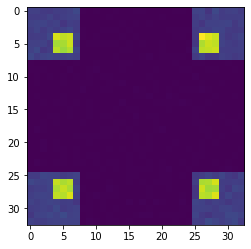

In [ ]:
if ndim == 2 :
    plt.imshow(samples_DB)
elif ndim == 4 :
    plt.imshow(samples_DB[0,0])
elif ndim == 6:  
    plt.imshow(samples_DB[0,0,0,0])
elif ndim == 8:
    plt.imshow(samples_DB[0,0,0,0,0,0])

In [ ]:
if ndim == 4 :
    tmp = samples_DB.sum((2,3))+samples_DB.sum((0,1))+samples_DB.sum((0,2))+samples_DB.sum((1,3))+samples_DB.sum((2,3))+samples_DB.sum((0,3))
    plt.imshow(tmp,vmin=0);plt.show()
    plt.imshow(samples_DB.sum((1,3)),vmin=0);plt.show()

## Flow matching objective

$$
\mathcal{L}_{FM} \big(s\big) = \left\{
    \begin{array}{ll}
        \bigg[ log \bigg( \epsilon + \sum_{s'' \rightarrow s} exp \text{ } F_{\theta}^{log}(s'', s) \bigg) - log \bigg( \epsilon + R(s) \bigg) \bigg]^2 & \mbox{if } s \mbox{ terminal} \\
        \bigg[ log \bigg( \epsilon + \sum_{s'' \rightarrow s} exp \text{ } F_{\theta} ^{log}(s'', s) \bigg) - log \bigg( \epsilon +  \sum_{s \rightarrow s'} exp \text{ } F_{\theta}^{log}(s, s') \bigg) \bigg]^2 & \mbox{else (s non-initial)}
    \end{array}
\right. 
$$


In [ ]:
epsilon = all_rewards.min()
#epsilon = 1e-6
epsilon

tensor(0.0100)



---


The following functions allow, in a given state, to find all its parents, to evaluate the model on these parents, and to consider the flow from the parents to the current state.

In [ ]:
def get_parents(state) :
    """
    Return the parents of a given state, and the trasitions leading from the parents to the current state
    For `state = [3., 1.]`, `parents = [[2., 1.], [3., 0.]]` and `transitions = [0, 1]`
    """
    assert state.sum() != 0.
    parents, transitions = [], []
    np = 0
    for i in range(ndim) :
        sp = state + 0
        if sp[i] > 0 :
            sp[i] -= 1
            np += 1
            # if sp.max() == H: # can't have a terminal parent
            #     np -= 1
            #     continue
            parents.append(sp)
            transitions.append(i)
    if np == 0 : return None, None
    return torch.stack(parents), torch.LongTensor(transitions)

def get_inflow_old(state, model) :
    """Return the in flow of a given state"""
    parents, transitions = get_parents(state)
    embed = one_hot_embedding(parents.long()) # (n_parents, embedding_dim)
    logF = model(embed) # (n_parents, ndim+1)
    return logF.gather(1, transitions.unsqueeze(1).to(device)).exp().sum()

It is better to store the parents of each state to accelerate the training

In [ ]:
all_parents = {get_state_index(state.long()) : get_parents(state) for state in grid if state.sum() != 0.}

In [ ]:
def get_inflow(state, model, stop_action = False) :
    """Return the in flow of a given state"""
    if stop_action:
        #parents, transitions = state.unsqueeze(0), torch.LongTensor([ndim])         
        # Any state can be a parent of the terminal state : the corresponding action is always ndim
        parents = grid.clone()
        transitions = torch.LongTensor([ndim]*grid.size(0)) 
    else :
        state_id = get_state_index(state.long().cpu())
        parents, transitions = all_parents.get(state_id, (None, None))
    if parents is not None :
        embed = one_hot_embedding(parents.long()) # (n_parents, embedding_dim)
        logF = model(embed.to(device)) # (n_parents, ndim+1)
        return logF.gather(1, transitions.unsqueeze(1).to(device)).exp().sum()
    #else : return torch.tensor(0.)

In [ ]:
# for debugging
def parents_flow(non_terminal_states, actions, model):
    a = actions[actions!=ndim]
    parents = []
    print(non_terminal_states.shape, a.shape)
    print(non_terminal_states, actions)
    for n, i in zip(non_terminal_states, a) :
        s = n+0
        s[i]-=1
        parents.append(s)
    parents = torch.stack(parents)
    print(parents)
    embed = one_hot_embedding(parents.long()) # (n_parents, embedding_dim)
    logF = model(embed.to(device)) # (n_parents, ndim+1)
    return logF.gather(1, a.unsqueeze(1).to(device)).exp().sum(dim=1)



---



In [ ]:
input_dim = ndim*(H+1) # embedding dim
output_dim = ndim+1 # ndim + 1 for F (+1 for stop action)
model_FM = make_mlp([input_dim] + [n_hid] * n_layers + [output_dim]).to(device)
logZ_FM = torch.zeros((1,)).to(device) # log (initial state flow), Z = 1
optimizer = torch.optim.Adam([{'params':model_FM.parameters(), 'lr':0.001}])

model_FM

Sequential(
  (0): Linear(in_features=66, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=256, out_features=3, bias=True)
)

In [ ]:
losses_FM = []
rewards_FM = []
logZ_FM_list = []
all_visited_FM = []
first_visit_FM = -1 * np.ones_like(true_dist)
l1log_FM = []

In [ ]:
# #batch_size = 128
# #batch_size = 8
# #epsilon = 1e-2
# for it in tqdm.trange(n_train_steps): 
# #for it in tqdm.trange(1000):    
#     # FM loss for each state of each trajectory : a trajectory can have a maximum length (#states) of `(H+1) + H + ... + H = (H+1) + (ndim-1)*H`
#     loss_FM = torch.zeros((batch_size, H+1+(ndim-1)*H +1)).to(device) # +1 for s_f
#     # finished trajectories
#     dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
#     # s_0
#     states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
#     # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
#     actions = None # (current_batch_size,)

#     current_batch_size = (~dones).sum()
#     non_terminal_states = states[~dones] # (current_batch_size, ndim)

#     i = 0
#     while True:
#         if actions is not None :
#             ### select terminals and non-terminal actions ### 
#             # non-terminals
#             terminates = (actions==ndim).squeeze(1)
#             termination_mask = ~dones
#             termination_mask[~dones] &= terminates
#             # terminals
#             non_terminates = (actions!=ndim).squeeze(1)
#             non_termination_mask = ~dones
#             non_termination_mask[~dones] &= non_terminates

#             ### In Flow : non-initial and non-terminal state ### 
#             if non_terminates.any(): 
#                 #inFlow = torch.stack([get_inflow(state, model_FM) for state in non_terminal_states[non_terminates]]) # (current_batch_size,)
#                 #inFlow = torch.tensor(0.) if i==0 else parents_flow(non_terminal_states[non_terminates], actions, model_FM)
#                 inFlow = logPF.gather(1, actions[actions!=ndim].unsqueeze(1)).exp().sum(dim=1)
#                 loss_FM[non_termination_mask,i] += (epsilon + inFlow).log()  

#             ### In Flow : terminal state ###
#             if terminates.any():
#                 # add log_sumF(., s_i) to the loss L(s_i)   
#                 inFlow = torch.stack([get_inflow(state, model_FM, stop_action=True) for state in non_terminal_states[terminates]]) # (current_batch_size,)
#                 loss_FM[termination_mask,i] += (epsilon + inFlow).log() 

#             ### Out Flow for non-terminal states : add -log_sumF(s_i, .) to the loss L(s_i) ###
#             #outFlow = logF[non_terminates].exp().sum(dim=-1)
#             outFlow = logPF[non_terminates].exp().sum(dim=-1)
#             loss_FM[non_termination_mask,i] -= (epsilon + outFlow).log()

#             ### Out Flow for terminal states : Add -reward for terminal state ###
#             R_x = reward_function(non_terminal_states[terminates].float())
#             loss_FM[termination_mask,i] -= (epsilon + R_x).log()

#             ### select terminal states ### 
#             for state in non_terminal_states[terminates]: 
#                 state_index = get_state_index(state.cpu())
#                 if first_visit_FM[state_index]<0: first_visit_FM[state_index] = it
#                 all_visited_FM.append(state_index)

#             # Update dones
#             dones[~dones] |= terminates

#             # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
#             with torch.no_grad():
#                 non_terminates = actions[~terminates]
#                 states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))

#             i += 1

#         if torch.any(~dones) :
#             ### Forward pass ### 
#             current_batch_size = (~dones).sum()
#             non_terminal_states = states[~dones] # (current_batch_size, ndim)
#             embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
#             logF = model_FM(embed) # (current_batch_size, output_dim = ndim+1) 

#             ### Forward Policy : tempered version of the state-action flow F ### 
#             # Being in a edge cell ++ (a coordinate that is H), we can't move forward
#             edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
#             # but any cell can be a terminal cell
#             stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
#             # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
#             PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
#             # logPF (with mask)
#             logPF = (logF + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
#             # choose next states
#             sample_temperature = 1
#             #exp_weight= 0.
#             #PF = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
#             PF = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
#             #actions = torch.distributions.categorical.Categorical(probs = PF).sample() # (current_batch_size,)
#             #actions = torch.multinomial(probs = PF, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
#             actions = PF.multinomial(1) # (current_batch_size,)
#         else :
#             break

#         if i==0 :
#             # initial state
#             #all_init_flow = logF.exp().sum(dim=1) # (current_batch_size,)
#             all_init_flow = logPF.exp().sum(dim=1) # (current_batch_size,)
#             #logZ_FM[:] = all_init_flow.mean().item() 
#             logZ_FM[:] = all_init_flow[0].item() # initial state)

#     loss_FM = loss_FM[:,1:] # remove L(s_0)
#     loss = (loss_FM**2).sum(dim=1).sum()/batch_size

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     losses_FM.append(loss.item())
#     R = reward_function(states.float())
#     rewards_FM.append(R.mean().cpu())
#     logZ_FM_list.append(logZ_FM.item())

#     if it%100==0: 
#         print('\nloss =', np.array(losses_FM[-100:]).mean(), 'logZ =', logZ_FM.item(), "R =", np.array(rewards_FM[-100:]).mean())
#         emp_dist = np.bincount(all_visited_FM[-200000:], minlength=len(true_dist)).astype(float)
#         emp_dist /= emp_dist.sum()
#         l1 = np.abs(true_dist-emp_dist).mean()
#         print('L1 =', l1)
#         l1log_FM.append((len(all_visited_FM), l1))

In [ ]:
for it in tqdm.trange(n_train_steps): 
#for it in tqdm.trange(100):    
    # FM loss for each state of each trajectory : a trajectory can have a maximum length (#states) of `(H+1) + H + ... + H = (H+1) + (ndim-1)*H`
    loss_FM = torch.zeros((batch_size, H+1+(ndim-1)*H)).to(device)
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
    # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
    actions = None # (current_batch_size,)

    i = 0
    while torch.any(~dones):

        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
        logF = model_FM(embed) # (current_batch_size, output_dim = ndim+1) 

        ### Forward Policy : tempered version of the state-action flow F ### 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # logPF (with mask)
        logPF = (logF + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        sample_temperature = 1
        #exp_weight= 0.
        #PF = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
        PF = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        #actions = torch.distributions.categorical.Categorical(probs = PF).sample() # (current_batch_size,)
        #actions = torch.multinomial(probs = PF, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
        actions = PF.multinomial(1) # (current_batch_size,)
        
        ### Out Flow for non-terminal states : add -log_sumF(s_i, .) to the loss L(s_i) ###
        non_terminates = (actions!=ndim).squeeze(1)
        termination_mask = ~dones
        termination_mask[~dones] &= non_terminates
        #outFlow = logF[non_terminates].exp().sum(dim=-1)
        outFlow = logPF[non_terminates].exp().sum(dim=-1)
        loss_FM[termination_mask,i] -= (epsilon + outFlow).log()

        ### In Flow : non-initial and non-terminal state ###
        if i!=0 :
            # add log_sumF(., s_i) to the loss L(s_i)
            #inFlow = torch.stack([get_inflow(state, model_FM) for state in non_terminal_states]) # (current_batch_size,)
            #loss_FM[~dones,i] += (epsilon + inFlow).log()    
            if non_terminates.any(): 
                inFlow = torch.stack([get_inflow(state, model_FM) for state in non_terminal_states[non_terminates]]) # (current_batch_size,)
                loss_FM[termination_mask,i] += (epsilon + inFlow).log()      
        else :
            # initial state
            #all_init_flow = logF.exp().sum(dim=1) # (current_batch_size,)
            all_init_flow = logPF.exp().sum(dim=1) # (current_batch_size,)
            #logZ_FM[:] = all_init_flow.mean().item() 
            logZ_FM[:] = all_init_flow[0].item() # initial state)

        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)
        for state in non_terminal_states[terminates]: 
            state_index = get_state_index(state.cpu())
            if first_visit_FM[state_index]<0: first_visit_FM[state_index] = it
            all_visited_FM.append(state_index)

        # Add -reward for terminal state : Out Flow for terminal states
        termination_mask = ~dones
        termination_mask[~dones] &= terminates
        R_x = reward_function(non_terminal_states[terminates].float())
        loss_FM[termination_mask,i] -= (epsilon + R_x).log()

        ### In Flow : terminal state ###
        if i!=0 and terminates.any():
            # add log_sumF(., s_i) to the loss L(s_i)   
            inFlow = torch.stack([get_inflow(state, model_FM, stop_action=True) for state in non_terminal_states[terminates]]) # (current_batch_size,)
            #print(inFlow, "===========", non_terminal_states[terminates])
            loss_FM[termination_mask,i] += (epsilon + inFlow).log()           

        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))

        i += 1
    
    loss_FM = loss_FM[:,1:] # remove L(s_0)
    loss = (loss_FM**2).sum(dim=1).sum()/batch_size

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_FM.append(loss.item())
    R = reward_function(states.float())
    rewards_FM.append(R.mean().cpu())
    logZ_FM_list.append(logZ_FM.item())

    if it%100==0: 
        print('\nloss =', np.array(losses_FM[-100:]).mean(), 'logZ =', logZ_FM.item(), "R =", np.array(rewards_FM[-100:]).mean())
        emp_dist = np.bincount(all_visited_FM[-200000:], minlength=len(true_dist)).astype(float)
        emp_dist /= emp_dist.sum()
        l1 = np.abs(true_dist-emp_dist).mean()
        print('L1 =', l1)
        l1log_FM.append((len(all_visited_FM), l1))

  0%|          | 1/5000 [00:01<2:10:45,  1.57s/it]


loss = 37.468482971191406 logZ = 1.0000001192092896 R = 0.52171874
L1 = 0.0017865315214705144


  2%|▏         | 101/5000 [08:47<8:20:33,  6.13s/it]


loss = 10.02450667567551 logZ = 1.0 R = 0.5090625
L1 = 0.0016239106400398762


  4%|▍         | 201/5000 [19:05<8:11:16,  6.14s/it]


loss = 0.13829539590980858 logZ = 1.0 R = 0.5062109
L1 = 0.0016876384215197093


  6%|▌         | 301/5000 [29:17<7:50:04,  6.00s/it]


loss = 0.12635590753518045 logZ = 0.9999999403953552 R = 0.5059375
L1 = 0.0017137194048126839


  7%|▋         | 374/5000 [36:40<7:33:41,  5.88s/it]


KeyboardInterrupt: ignored

In [ ]:
#loss_FM[:,1:], loss_FM.shape

In [ ]:
#loss_FM[loss_FM != 0].shape

### samples

In [ ]:
#model_FM, logZ_FM, losses_FM, rewards_FM, logZ_FM_list, all_visited_FM, first_visit_FM, l1log_FM = data["FM"]

In [ ]:
samples_FM = np.zeros((H+1,)*ndim)

In [ ]:
# #batch_size = 128
# #batch_size = 8
# #batch_size = 1
# epsilon = 1e-2
# for it in tqdm.trange(100):    
#     # finished trajectories
#     dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
#     # s_0
#     states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
#     # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
#     actions = None # (current_batch_size,)

#     current_batch_size = (~dones).sum()
#     non_terminal_states = states[~dones] # (current_batch_size, ndim)

#     i = 0
#     while torch.any(~dones):

#         if actions is not None :  
#             ### select terminal states ### 
#             terminates = (actions==ndim).squeeze(1)

#             # Update dones
#             dones[~dones] |= terminates

#             # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
#             with torch.no_grad():
#                 non_terminates = actions[~terminates]
#                 states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))
#             i += 1

#         if torch.any(~dones) :
#             ### Forward pass ### 
#             current_batch_size = (~dones).sum()
#             non_terminal_states = states[~dones] # (current_batch_size, ndim)
#             embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
#             logF = model_FM(embed) # (current_batch_size, output_dim = ndim+1) 

#             ### Forward Policy : tempered version of the state-action flow F ### 
#             # Being in a edge cell ++ (a coordinate that is H), we can't move forward
#             edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
#             # but any cell can be a terminal cell
#             stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
#             # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
#             PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
#             # logPF (with mask)
#             logPF = (logF + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
#             # choose next states
#             sample_temperature = 1
#             #exp_weight= 0.
#             #PF = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
#             PF = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
#             #actions = torch.distributions.categorical.Categorical(probs = PF).sample() # (current_batch_size,)
#             #actions = torch.multinomial(probs = PF, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
#             actions = PF.multinomial(1) # (current_batch_size,)
#         else :
#             break

#     if ndim == 8 :
#         for a,b,c,d,e,f,g,h in states: samples_FM[a,b,c,d,e,f,g,h]+=1  
#     if ndim == 6 :
#         for a,b,c,d,e,f in states: samples_FM[a,b,c,d,e,f]+=1         
#     if ndim == 4 :
#         for a,b,c,d in states: samples_FM[a,b,c,d]+=1
#     elif ndim == 2 :
#         for a,b in states: samples_FM[a,b]+=1

In [ ]:
for it in tqdm.trange(500):    
    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)
    # actions chosen at each step : we can choose the coordinate to increment (0 ... ndim-1), or choose to return the current state as terminal (ndim)
    actions = None # (current_batch_size,)

    while torch.any(~dones):

        ### Forward pass ### 
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        embed = one_hot_embedding(non_terminal_states) # (current_batch_size, input_dim)
        with torch.no_grad():
            logF = model_FM(embed) # (current_batch_size, output_dim = ndim+1) 

        ### Forward Policy : tempered version of the flow F ### 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # logPF (with mask)
        logPF = (logF + minus_inf*PF_mask).log_softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        sample_temperature = 1
        #exp_weight= 0.
        #PF = (1-exp_weight)*(logPF/sample_temperature).softmax(1) + exp_weight*(1-PF_mask) / (1-PF_mask+0.0000001).sum(1).unsqueeze(1) # (current_batch_size, ndim+1)
        PF = (logPF/sample_temperature).softmax(1) # (current_batch_size, ndim+1)
        #actions = torch.distributions.categorical.Categorical(probs = PF).sample() # (current_batch_size,)
        #actions = torch.multinomial(probs = PF, 1).squeeze(1) # (current_batch_size,) # (current_batch_size,)
        actions = PF.multinomial(1) # (current_batch_size,)
        
        ### select terminal states ### 
        terminates = (actions==ndim).squeeze(1)

        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))

    if ndim == 8 :
        for a,b,c,d,e,f,g,h in states: samples_FM[a,b,c,d,e,f,g,h]+=1  
    if ndim == 6 :
        for a,b,c,d,e,f in states: samples_FM[a,b,c,d,e,f]+=1         
    if ndim == 4 :
        for a,b,c,d in states: samples_FM[a,b,c,d]+=1
    elif ndim == 2 :
        for a,b in states: samples_FM[a,b]+=1

100%|██████████| 500/500 [00:38<00:00, 13.11it/s]


In [ ]:
if ndim == 2 :
    print(samples_FM / samples_FM.sum())

[[1.18906250e-02 1.10937500e-03 1.06250000e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.93750000e-04 7.81250000e-05 9.37500000e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.78125000e-04 7.81250000e-05 7.81250000e-05 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.18750000e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.68750000e-05
  4.68750000e-05 3.75000000e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.90625000e-04
  3.12500000e-04 9.64609375e-01]]


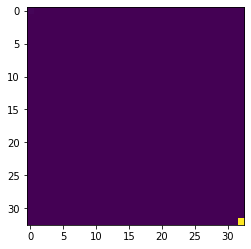

In [ ]:
if ndim == 2 :
    plt.imshow(samples_FM)
elif ndim == 4 :
    plt.imshow(samples_FM[0,0])
elif ndim == 6:  
    plt.imshow(samples_FM[0,0,0,0])
elif ndim == 8:
    plt.imshow(samples_FM[0,0,0,0,0,0])

In [ ]:
if ndim == 4 :
    tmp = samples_FM.sum((2,3))+samples_FM.sum((0,1))+samples_FM.sum((0,2))+samples_FM.sum((1,3))+samples_FM.sum((2,3))+samples_FM.sum((0,3))
    plt.imshow(tmp,vmin=0);plt.show()
    plt.imshow(samples_FM.sum((1,3)),vmin=0);plt.show()

**This implementation has a problem. Refer to this official implementation for the moment : https://github.com/GFNOrg/gflownet**

## Random (uniform) agent

In [ ]:
rewards_random = []
all_visited_random = []
first_visit_random = -1 * np.ones_like(true_dist)
l1log_random = []

In [ ]:
for it in tqdm.trange(n_train_steps):

    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)

    while torch.any(~dones) : #and i <= max_length_traj :
        # Forward pass
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        
        ### Uniform Forward Policy ### 
        PF_logits = torch.ones(current_batch_size, ndim+1).to(device) # (current_batch_size, ndim+1) 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # PF (with mask)
        PF = (PF_logits + minus_inf*PF_mask).softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        #actions = torch.from_numpy(np.random.choice(np.arange(ndim+1), size=(current_batch_size,1), p = PF))
        actions = PF.multinomial(1)
        #if i == max_length_traj : actions = torch.LongTensor(current_batch_size,1).fill_(ndim)
        # select terminal states
        terminates = (actions==ndim).squeeze(1)
        for state in non_terminal_states[terminates]: 
            state_index = get_state_index(state.cpu())
            if first_visit_random[state_index]<0: first_visit_random[state_index] = it
            all_visited_random.append(state_index)
        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))

    R = reward_function(states.float())
    rewards_random.append(R.mean().cpu())
    if it%100==0: 
        print("\nR =", np.array(rewards_random[-100:]).mean())
        emp_dist = np.bincount(all_visited_random[-200000:], minlength=len(true_dist)).astype(float)
        emp_dist /= emp_dist.sum()
        l1 = np.abs(true_dist-emp_dist).mean()
        print('L1 =', l1)
        l1log_random.append((len(all_visited_random), l1))

  1%|          | 28/5000 [00:00<00:37, 134.30it/s]


R = 0.56078124
L1 = 0.0017376550792586453


  3%|▎         | 126/5000 [00:00<00:37, 131.04it/s]


R = 0.5359375
L1 = 0.0017140249790238


  4%|▍         | 225/5000 [00:01<00:35, 135.30it/s]


R = 0.53457034
L1 = 0.0017120312267684093


  7%|▋         | 326/5000 [00:02<00:34, 135.06it/s]


R = 0.5333203
L1 = 0.0017131362376799882


  9%|▊         | 427/5000 [00:03<00:32, 139.30it/s]


R = 0.53375
L1 = 0.0017138316416154418


 10%|█         | 524/5000 [00:03<00:34, 128.66it/s]


R = 0.53515625
L1 = 0.0017128747780434097


 12%|█▏        | 621/5000 [00:04<00:33, 131.85it/s]


R = 0.5325781
L1 = 0.0017133583968721338


 14%|█▍        | 722/5000 [00:05<00:32, 132.68it/s]


R = 0.5310938
L1 = 0.00171384731158422


 16%|█▋        | 823/5000 [00:06<00:30, 138.75it/s]


R = 0.53367186
L1 = 0.0017139454605933197


 18%|█▊        | 922/5000 [00:06<00:30, 135.15it/s]


R = 0.5351953
L1 = 0.0017140058983620959


 20%|██        | 1024/5000 [00:07<00:30, 128.63it/s]


R = 0.5348828
L1 = 0.0017140972617286539


 22%|██▏       | 1124/5000 [00:08<00:29, 133.16it/s]


R = 0.5376172
L1 = 0.0017138592651584348


 24%|██▍       | 1221/5000 [00:09<00:29, 129.75it/s]


R = 0.5371875
L1 = 0.0017134339137385257


 26%|██▋       | 1320/5000 [00:09<00:27, 131.94it/s]


R = 0.5285938
L1 = 0.0017138569713190084


 28%|██▊       | 1425/5000 [00:10<00:25, 137.99it/s]


R = 0.5313672
L1 = 0.0017141991526914114


 31%|███       | 1526/5000 [00:11<00:24, 139.57it/s]


R = 0.5396094
L1 = 0.0017139126426295094


 32%|███▎      | 1625/5000 [00:12<00:25, 129.99it/s]


R = 0.53378904
L1 = 0.0017138104823922876


 34%|███▍      | 1722/5000 [00:12<00:25, 126.34it/s]


R = 0.5339453
L1 = 0.0017137348756498057


 36%|███▋      | 1820/5000 [00:13<00:24, 127.43it/s]


R = 0.5342187
L1 = 0.001713679779231073


 38%|███▊      | 1919/5000 [00:14<00:23, 132.44it/s]


R = 0.5319922
L1 = 0.0017137165101768948


 40%|████      | 2019/5000 [00:15<00:22, 132.19it/s]


R = 0.5326172
L1 = 0.001713900164906004


 42%|████▏     | 2117/5000 [00:15<00:22, 127.14it/s]


R = 0.5359766
L1 = 0.0017139277131153702


 44%|████▍     | 2211/5000 [00:16<00:23, 117.49it/s]


R = 0.5358203
L1 = 0.0017138358857508155


 46%|████▋     | 2321/5000 [00:17<00:20, 129.16it/s]


R = 0.5326953
L1 = 0.0017135625485079902


 48%|████▊     | 2417/5000 [00:18<00:19, 130.52it/s]


R = 0.530625
L1 = 0.0017135858070156797


 50%|█████     | 2516/5000 [00:19<00:19, 128.28it/s]


R = 0.5366797
L1 = 0.0017137348756498054


 52%|█████▏    | 2615/5000 [00:19<00:18, 126.86it/s]


R = 0.5342969
L1 = 0.0017135971346029736


 54%|█████▍    | 2713/5000 [00:20<00:18, 124.15it/s]


R = 0.5313672
L1 = 0.0017138267030143604


 57%|█████▋    | 2827/5000 [00:21<00:16, 132.85it/s]


R = 0.5324219
L1 = 0.0017137624238591721


 58%|█████▊    | 2913/5000 [00:22<00:16, 128.49it/s]


R = 0.53339845
L1 = 0.0017136155000758845


 60%|██████    | 3014/5000 [00:22<00:15, 128.89it/s]


R = 0.5359766
L1 = 0.0017133583834551315


 62%|██████▏   | 3117/5000 [00:23<00:13, 136.06it/s]


R = 0.53414065
L1 = 0.001713330835245765


 64%|██████▍   | 3216/5000 [00:24<00:13, 129.87it/s]


R = 0.5328125
L1 = 0.0017135144899748744


 66%|██████▌   | 3312/5000 [00:25<00:14, 119.62it/s]


R = 0.53292966
L1 = 0.0017139552613247367


 68%|██████▊   | 3424/5000 [00:26<00:12, 123.23it/s]


R = 0.53324217
L1 = 0.00171382670301436


 71%|███████   | 3527/5000 [00:26<00:10, 134.10it/s]


R = 0.53777343
L1 = 0.0017134502108196864


 73%|███████▎  | 3626/5000 [00:27<00:10, 128.40it/s]


R = 0.53160155
L1 = 0.0017134777590290524


 75%|███████▍  | 3727/5000 [00:28<00:09, 135.40it/s]


R = 0.5358203
L1 = 0.0017136063173394292


 77%|███████▋  | 3826/5000 [00:29<00:08, 133.56it/s]


R = 0.5351172
L1 = 0.0017134410280832308


 79%|███████▊  | 3929/5000 [00:29<00:07, 134.30it/s]


R = 0.5358203
L1 = 0.0017130186222062793


 80%|████████  | 4016/5000 [00:30<00:07, 131.88it/s]


R = 0.53457034
L1 = 0.0017130278049427349


 82%|████████▏ | 4116/5000 [00:31<00:06, 127.96it/s]


R = 0.53378904
L1 = 0.0017127064091667936


 84%|████████▍ | 4215/5000 [00:31<00:06, 128.03it/s]


R = 0.53414065
L1 = 0.0017126421300116053


 86%|████████▋ | 4316/5000 [00:32<00:05, 135.04it/s]


R = 0.53621095
L1 = 0.001712763650436365


 88%|████████▊ | 4414/5000 [00:33<00:04, 129.09it/s]


R = 0.53578126
L1 = 0.0017127544676999095


 91%|█████████ | 4527/5000 [00:34<00:03, 132.06it/s]


R = 0.5358203
L1 = 0.0017125319371741395


 92%|█████████▏| 4618/5000 [00:34<00:02, 139.67it/s]


R = 0.5319531
L1 = 0.0017127177367540873


 94%|█████████▍| 4722/5000 [00:35<00:02, 137.77it/s]


R = 0.53589845
L1 = 0.0017128922087467416


 96%|█████████▋| 4821/5000 [00:36<00:01, 132.19it/s]


R = 0.53621095
L1 = 0.0017125962163293282


 98%|█████████▊| 4919/5000 [00:37<00:00, 125.92it/s]


R = 0.5360547
L1 = 0.0017125227544376844


100%|██████████| 5000/5000 [00:37<00:00, 132.16it/s]


### samples

In [ ]:
samples_random = np.zeros((H+1,)*ndim)

In [ ]:
for it in tqdm.trange(500):

    # finished trajectories
    dones = torch.full((batch_size,), False, dtype=torch.bool).to(device)
    # s_0
    states = torch.zeros((batch_size, ndim), dtype=torch.long).to(device)

    while torch.any(~dones) : #and i <= max_length_traj :
        # Forward pass
        current_batch_size = (~dones).sum()
        non_terminal_states = states[~dones] # (current_batch_size, ndim)
        
        ### Uniform Forward Policy ### 
        PF_logits = torch.ones(current_batch_size, ndim+1).to(device) # (current_batch_size, ndim+1) 
        # Being in a edge cell ++ (a coordinate that is H), we can't move forward
        edge_mask = (non_terminal_states == H).float() # (current_batch_size, ndim)
        # but any cell can be a terminal cell
        stop_action_mask = torch.zeros((current_batch_size, 1), device=device) # (current_batch_size, 1)
        # Being in a edge cell, we can't move forward, but any cell can be a terminal cell
        PF_mask = torch.cat([edge_mask, stop_action_mask], 1) # (current_batch_size, ndim+1)
        # PF (with mask)
        PF = (PF_logits + minus_inf*PF_mask).softmax(1) # (current_batch_size, ndim+1)
        # choose next states
        #actions = torch.from_numpy(np.random.choice(np.arange(ndim+1), size=(current_batch_size,1), p = PF))
        actions = PF.multinomial(1)
        #if i == max_length_traj : actions = torch.LongTensor(current_batch_size,1).fill_(ndim)
        # select terminal states
        terminates = (actions==ndim).squeeze(1)
 
        # Update dones
        dones[~dones] |= terminates

        # Update non completed trajectories : $s = (s^0, ..., s^i, ..., s^{n-1}) \rightarrow s' = (s^0, ..., s^i + 1, ..., s^{n-1})$
        with torch.no_grad():
            non_terminates = actions[~terminates]
            states[~dones] = states[~dones].scatter_add(1, non_terminates, torch.ones(non_terminates.shape, dtype=torch.long, device=device))

    if ndim == 8 :
        for a,b,c,d,e,f,g,h in states: samples_random[a,b,c,d,e,f,g,h]+=1  
    if ndim == 6 :
        for a,b,c,d,e,f in states: samples_random[a,b,c,d,e,f]+=1         
    if ndim == 4 :
        for a,b,c,d in states: samples_random[a,b,c,d]+=1
    elif ndim == 2 :
        for a,b in states: samples_random[a,b]+=1

100%|██████████| 500/500 [00:02<00:00, 182.55it/s]


In [ ]:
if ndim == 2 :
    print(samples_random / samples_random.sum())

[[0.33409375 0.1101875  0.03796875 ... 0.         0.         0.        ]
 [0.11054688 0.07403125 0.03682813 ... 0.         0.         0.        ]
 [0.03571875 0.03742188 0.02507812 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


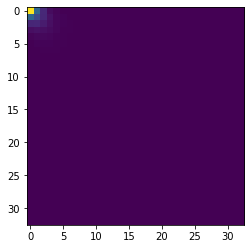

In [ ]:
if ndim == 2 :
    plt.imshow(samples_random)
elif ndim == 4 :
    plt.imshow(samples_random[0,0])
elif ndim == 6:  
    plt.imshow(samples_random[0,0,0,0])
elif ndim == 8:
    plt.imshow(samples_random[0,0,0,0,0,0])

In [ ]:
if ndim == 4 :
    tmp = samples_random.sum((2,3))+samples_random.sum((0,1))+samples_random.sum((0,2))+samples_random.sum((1,3))+samples_random.sum((2,3))+samples_random.sum((0,3))
    plt.imshow(tmp,vmin=0);plt.show()
    plt.imshow(samples_random.sum((1,3)),vmin=0);plt.show()

## Saves models

In [ ]:
data = {
    "TB" : [model_TB, logZ_TB, losses_TB, rewards_TB, logZ_TB_list, all_visited_TB, first_visit_TB, l1log_TB],
    "DB" : [model_DB, logZ_DB, losses_DB, rewards_DB, logZ_DB_list, all_visited_DB, first_visit_DB, l1log_DB],
    "FM" : [model_FM, logZ_FM, losses_FM, rewards_FM, logZ_FM_list, all_visited_FM, first_visit_FM, l1log_FM],
    "random" : [None, None, None, rewards_random, None, all_visited_random, first_visit_random, l1log_random],
}

torch.save(data, "/content/data_gfn.pth")

## Plot

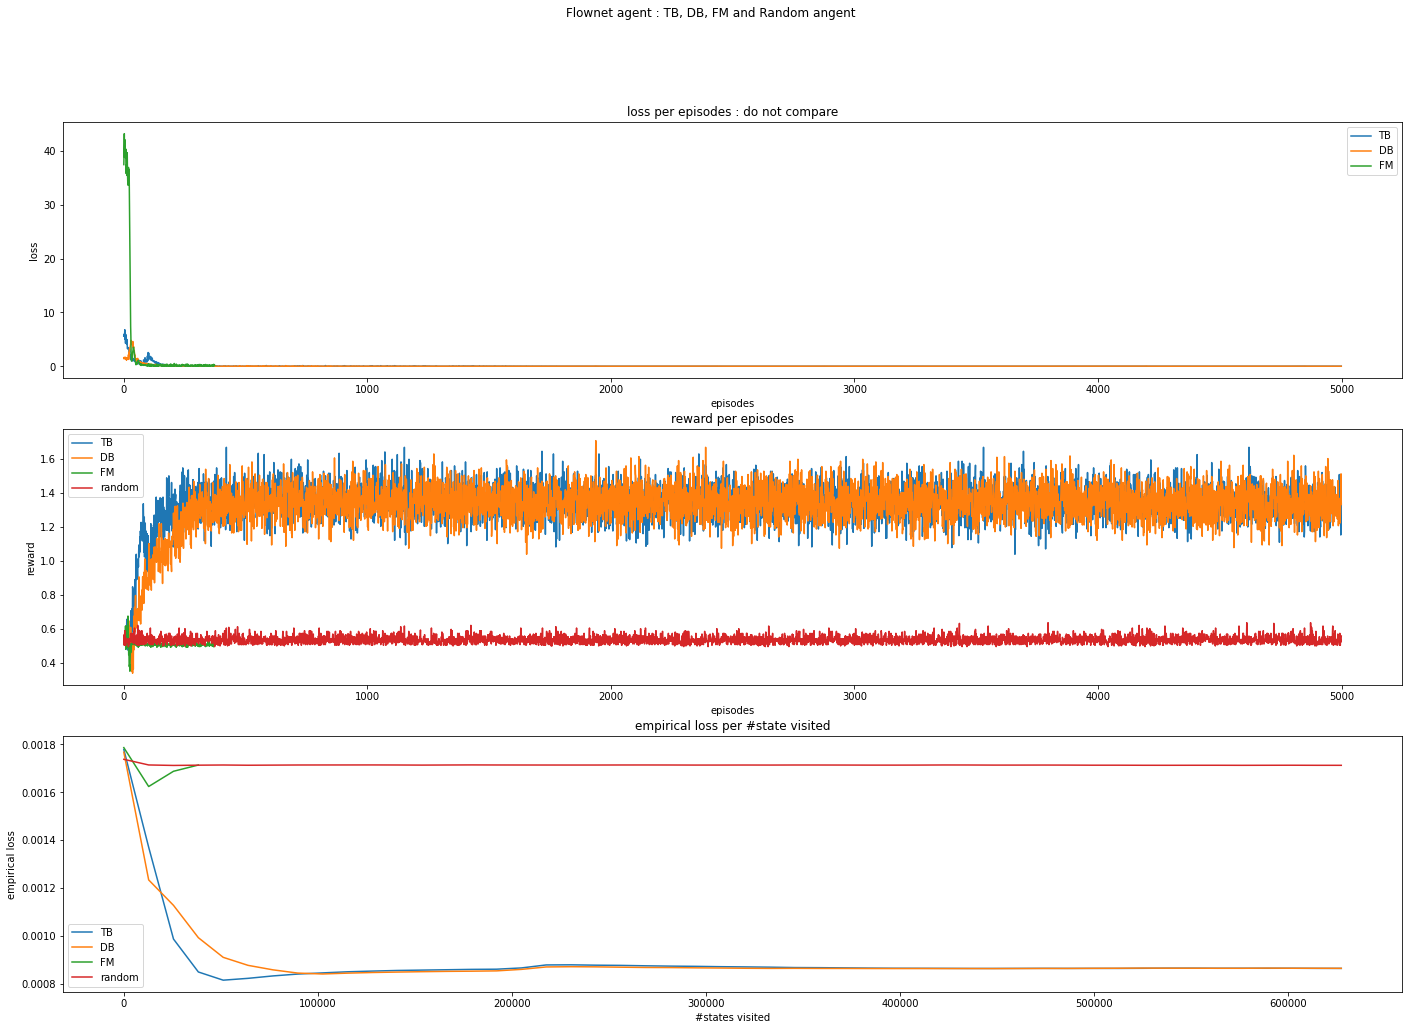

In [ ]:
figsize=(6*4,4*4)
#fig, (ax1, ax2, ax3, ax4)  = plt.subplots(4, 1, sharex=False, sharey=False, figsize = figsize)
fig, (ax1, ax2, ax3)  = plt.subplots(3, 1, sharex=False, sharey=False, figsize = figsize)
fig.suptitle("Flownet agent : TB, DB, FM and Random angent")

## loss
xs_TB = list(range(len(losses_TB)))
ax1.plot(xs_TB, losses_TB, label="TB")
#-
xs_DB = list(range(len(losses_DB)))
ax1.plot(xs_DB, losses_DB, label="DB")
#-
xs_FM = list(range(len(losses_FM)))
ax1.plot(xs_FM, losses_FM, label="FM")
#-
ax1.set(xlabel='episodes', ylabel='loss')
ax1.set_title('loss per episodes : do not compare')
ax1.legend()

## rewards
ax2.plot(xs_TB, rewards_TB, label="TB")
ax2.plot(xs_DB, rewards_DB, label="DB")
ax2.plot(xs_FM, rewards_FM, label="FM")
xs_random = list(range(len(rewards_random)))
ax2.plot(xs_random, rewards_random, label="random")
ax2.set(xlabel='episodes', ylabel='reward')
ax2.set_title('reward per episodes')
ax2.legend()

## empirical loss
xs = [a[0] for a in l1log_TB]
emp_loss_TB = [a[1] for a in l1log_TB]
ax3.plot(xs, emp_loss_TB, label="TB")
#-
xs = [a[0] for a in l1log_DB]
emp_loss_DB = [a[1] for a in l1log_DB]
ax3.plot(xs, emp_loss_DB, label="DB")
#-
xs = [a[0] for a in l1log_FM]
emp_loss_FM = [a[1] for a in l1log_FM]
ax3.plot(xs, emp_loss_FM, label="FM")
#-
xs = [a[0] for a in l1log_random]
emp_loss_random = [a[1] for a in l1log_random]
ax3.plot(xs, emp_loss_random, label="random")
#-
ax3.set(xlabel='#states visited', ylabel='empirical loss')
ax3.set_title('empirical loss per #state visited')
ax3.legend()


# ## empiciral loss
# xs = list(range(len(emp_loss_TB)))
# ax4.plot(xs, emp_loss_TB, label="TB")
# #-
# xs = list(range(len(emp_loss_DB)))
# ax4.plot(xs, emp_loss_DB, label="DB")
# #-
# xs = list(range(len(emp_loss_FM)))
# ax4.plot(xs, emp_loss_FM, label="FM")
# #-
# xs = list(range(len(emp_loss_random)))
# ax4.plot(xs, emp_loss_random, label="random")
# #-
# ax4.set(xlabel='#states visited', ylabel='empirical loss')
# ax4.set_title('empirical loss per epoch')
# ax4.legend()



---



In [ ]:
#threshold = R0+R1 if H < 8 else R0+R1+R2
threshold = all_rewards.max()

modes = all_rewards >= threshold
n_modes = modes.sum()
print(n_modes)

max_steps = None
#max_steps = 1000

# modes_founds_TB, xs_TB = get_modes_founds_old(first_visit_TB, threshold, max_steps)
# modes_founds_DB, xs_DB = get_modes_founds_old(first_visit_DB, threshold, max_steps)
# modes_founds_FM, xs_FM = get_modes_founds_old(first_visit_FM, threshold, max_steps)
# modes_founds_random, xs_random = get_modes_founds_old(first_visit_random, threshold, max_steps)

modes_founds_TB, xs_TB = get_modes_founds(first_visit_TB, modes, max_steps)
modes_founds_DB, xs_DB = get_modes_founds(first_visit_DB, modes, max_steps)
modes_founds_FM, xs_FM = get_modes_founds(first_visit_FM, modes, max_steps)
modes_founds_random, xs_random = get_modes_founds(first_visit_random, modes, max_steps) 

tensor(36)


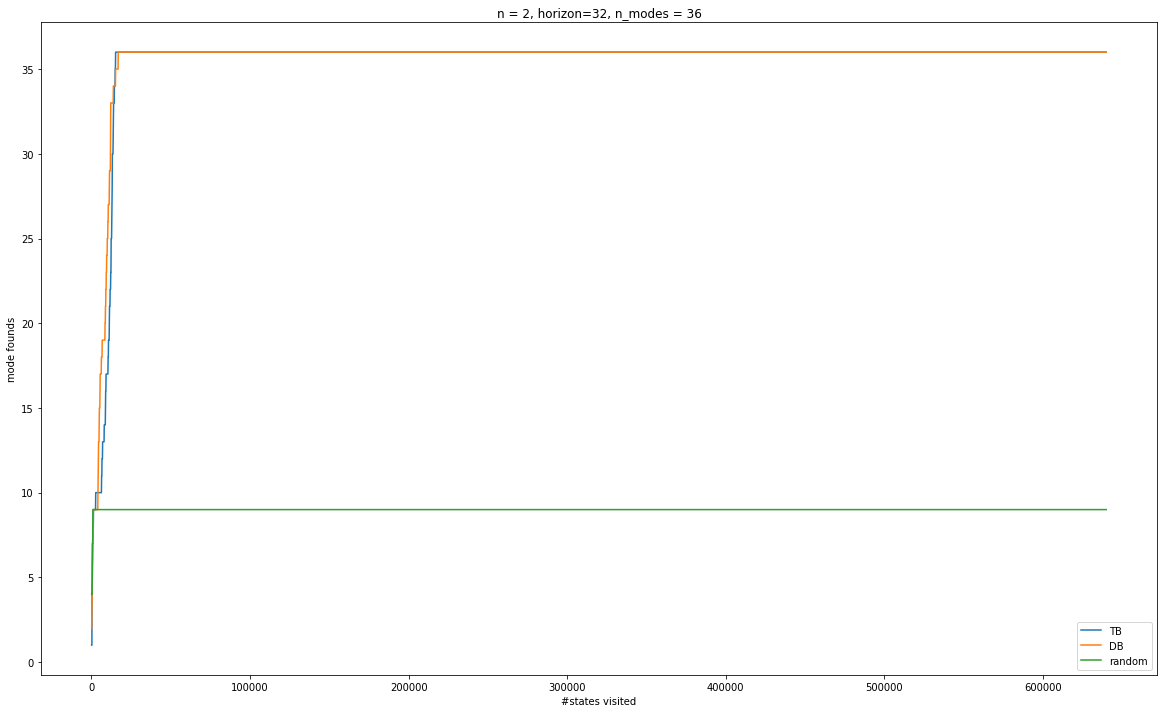

In [ ]:
figsize=(5*4,3*4)
fig, ax1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize = figsize)

ax1.plot(xs_TB, modes_founds_TB, label="TB")
ax1.plot(xs_DB, modes_founds_DB, label="DB")
#ax1.plot(xs_FM, modes_founds_FM, label="FM")
ax1.plot(xs_random, modes_founds_random, label="random")
ax1.set(xlabel='#states visited', ylabel='mode founds')
ax1.set_title(f'n = {ndim}, horizon={H}, n_modes = {n_modes}')
ax1.legend()

# Load pretrained models and sample with



In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = torch.load("/content/data_gfn.pth", map_location=device)

Run the samples sections above